In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa

from IPython.display import Audio
import matplotlib
import scipy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


from neurovoc import bruce, reconstruct, specres

data_path = "../data"

def get_spectrogram(y, sr, n_fft, hops):
    S = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=64, 
        fmin=150, 
        fmax=10_500,
        n_fft=n_fft, 
        hop_length=hops
    )

    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

n_mels = 64
min_freq = 150
max_freq = 10_500
mel_scale = librosa.filters.mel_frequencies(n_mels, fmin=min_freq, fmax=max_freq)

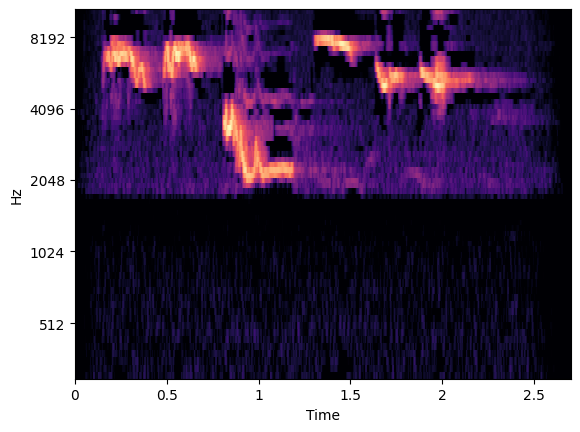

In [3]:
y, sr = librosa.load(librosa.ex('robin'))

n_fft = 512
hops = 32
S_db = get_spectrogram(y, sr, n_fft, hops)
librosa.display.specshow(S_db, x_axis='time',
                         y_axis='mel', sr=sr,
                          fmin=150, fmax=10_500, 
                         n_fft=n_fft, hop_length=hops)

In [4]:
import soundfile as sf

def librosa_ex_to_wav(name = 'robin'):
    tgt = os.path.join(data_path, f"{name}.wav")
    if os.path.isfile(tgt):
        return tgt
    sf.write(tgt, *librosa.load(librosa.ex(name)))
    assert os.path.isfile(tgt)
    return tgt
    
robin_sound = librosa_ex_to_wav()
trumpet_sound = librosa_ex_to_wav('trumpet')

In [5]:
neurogram = bruce(robin_sound)

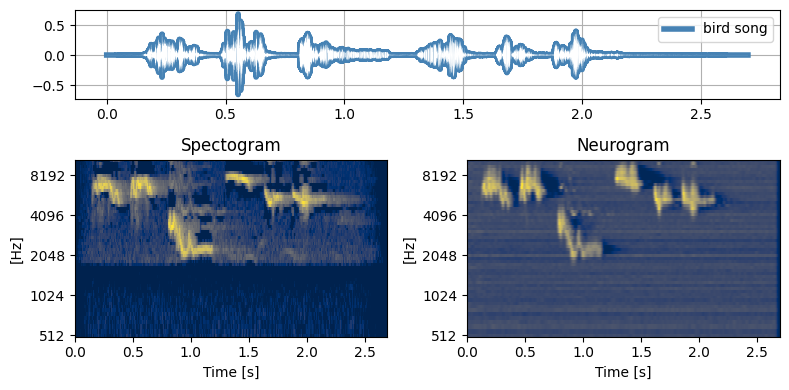

In [5]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 2,  height_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(np.arange(len(y)) * (1/sr), y, label='bird song', color='#4682B4', linewidth=4)
ax1.plot(np.arange(len(y)) * (1/sr), y, color='white', linewidth=.05)
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
t = np.arange(S_db.shape[1]) * hops * (1 / sr)
cmap = 'cividis'

ax2.pcolormesh(
    t, neurogram.frequencies, S_db, cmap=cmap
)

ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)

sp_data = np.vstack(
    [
        scipy.signal.resample(neurogram.data[i], S_db.shape[1])
        for i in range(neurogram.data.shape[0])
    ]
)

img = ax3.pcolormesh(
    t, neurogram.frequencies, sp_data, cmap=cmap
)
ax2.set_title("Spectogram")
ax3.set_title("Neurogram")

ax2.set_ylabel("[Hz]")
ax2.set_yscale("log", base=2)
ax2.set_yticks([pow(2, i) for i in range(9, 14)], [pow(2, i) for i in range(9, 14)])
ax2.set_ylim(500, None)
ax2.set_xlim(0, np.max(t))

# ax1.set_ylabel("amplitude")
ax3.set_ylabel("[Hz]")

for ax in ax2, ax3:
    ax.set_xlabel("Time [s]")
plt.tight_layout()

In [6]:
import phast

In [7]:
tp = phast.threshold_profile.load_df120()

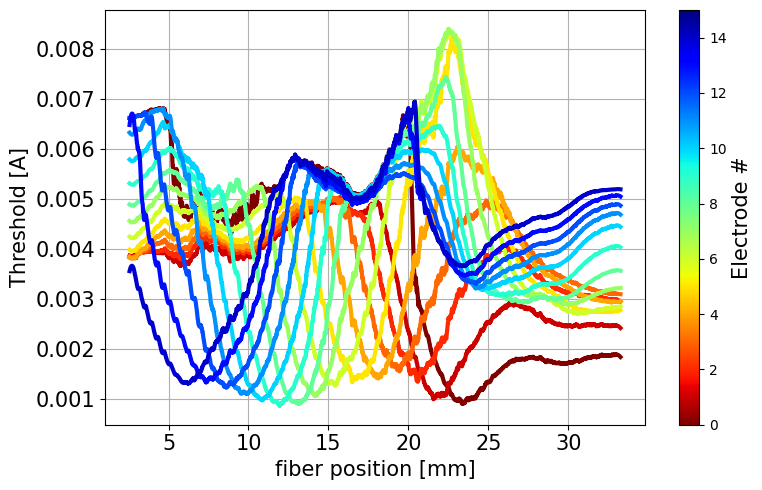

In [8]:
from scipy.signal import savgol_filter
from matplotlib import colors, cm

cmap = plt.cm.jet.reversed()
norm = colors.Normalize(vmin=0, vmax=135/9)

fig, ax = plt.subplots(figsize=(8, 5))
for e in range(0, 135, 9):
    ax.plot(tp.position, savgol_filter(tp.i_det[:, e], 50, 2), color=cmap(norm(e / 9)), linewidth=3)

sm = cm.ScalarMappable(cmap=cmap, norm=norm) 
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Electrode #", size=15)
ax.grid()
ax.set_xlabel("fiber position [mm]", fontsize=15)
ax.set_ylabel("Threshold [A]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# fig.savefig("t_profile.png", dpi=120)


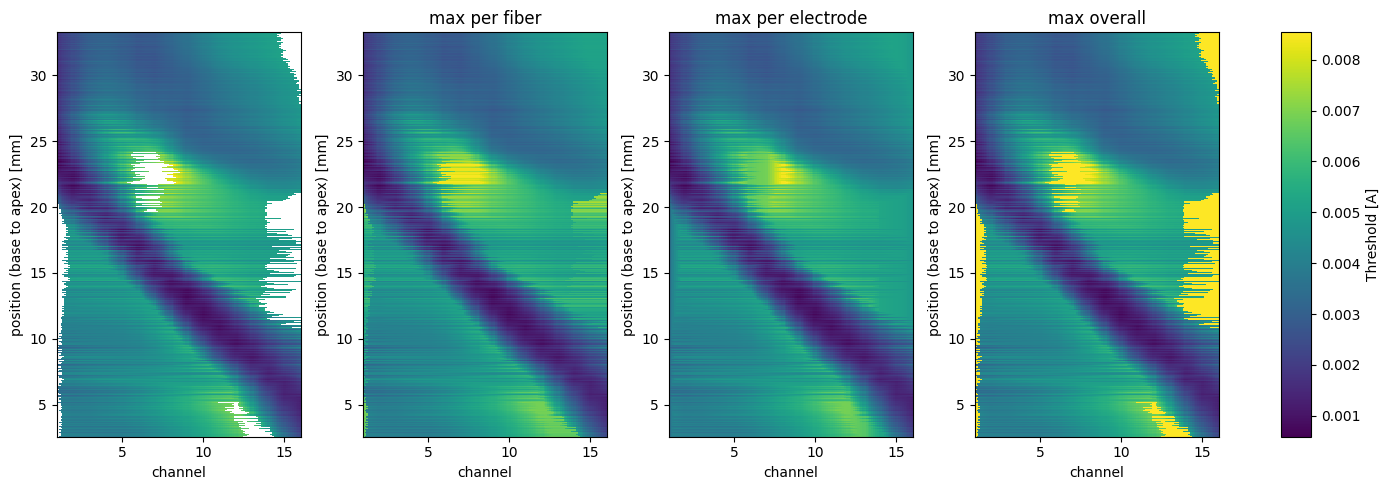

In [9]:
from phast.threshold_profile import *

def load_tp(ft: FiberType = FiberType.HEALTHY, fill=0):
    fname = os.path.join(DATA_DIR, "df120.npy")
    data = np.load(fname, allow_pickle=True).item()
    elec = ElectrodeConfiguration(
        m_level=data["M"][ft.value] * 1e-3,
        t_level=data["T"][ft.value] * 1e-3,
        insertion_angle=data["Ae"][ft.value],
        greenwood_f=data["Fe"][ft.value] * 1e3,
        position=data["Le"][ft.value],
        alpha=data["alpha"][ft.value],
    )
    TIa = data["TIa"][ft.value] * 1e-3
    TIb = data["TIb"][ft.value] * 1e-3
    i_det = TIa + TIb
    i_det = np.flip(i_det[:, : i_det.shape[1], :].reshape(-1, i_det.shape[2]).T, axis=0)

    if fill == 1:
        i_det = np.nan_to_num(i_det, nan=np.nanmax(i_det, axis=1).reshape(-1, 1))
    elif fill == 2:
        i_det = np.nan_to_num(i_det, nan=np.nanmax(i_det, axis=0))
    elif fill == 3:
        i_det = np.nan_to_num(i_det, nan=np.nanmax(i_det))

    tp = ThresholdProfile(
        i_det=i_det,
        electrode=elec,
        angle=np.flip(data["An"][ft.value]),
        position=np.flip(data["Ln"][ft.value]),
        greenwood_f=np.flip(data["Fn"][ft.value] * 1e3),
        fiber_type=ft,
    )
    return tp

fig, axes = plt.subplots(1, 5, figsize=(14, 5), gridspec_kw={'width_ratios': [8, 8, 8, 8, 1]})

for i, ax in enumerate(axes[:4]):
    tp = load_tp(fill=i)
    img = ax.pcolormesh(1 + np.linspace(0, 15, tp.i_det.shape[1]), tp.position, tp.i_det)
    ax.set_xlabel("channel")
    ax.set_ylabel("position (base to apex) [mm]")
    
axes[1].set_title("max per fiber")
axes[2].set_title("max per electrode")
axes[3].set_title("max overall")

fig.colorbar(img, axes[4]).set_label("Threshold [A]")
plt.tight_layout()

/tmp/ipykernel_2057422/362155425.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  img = ax.pcolormesh(1 + np.linspace(0, 15, tp.i_det.shape[1]), tp.position, tp.i_det, cmap=plt.cm.get_cmap('cividis').reversed())


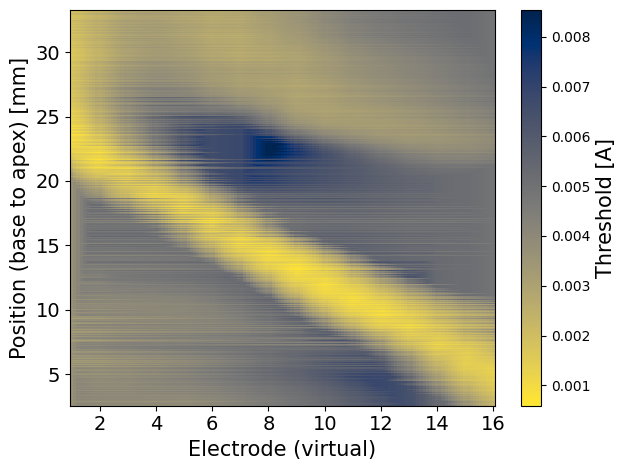

In [10]:
f, ax = plt.subplots()
tp = load_tp(fill=2)

img = ax.pcolormesh(1 + np.linspace(0, 15, tp.i_det.shape[1]), tp.position, tp.i_det, cmap=plt.cm.get_cmap('cividis').reversed())
ax.set_xlabel("Electrode (virtual)", fontsize=15)
ax.set_ylabel("Position (base to apex) [mm]", fontsize=15)
plt.colorbar(img).set_label("Threshold [A]", size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig("heatmap_t_profile.png", dpi=400)


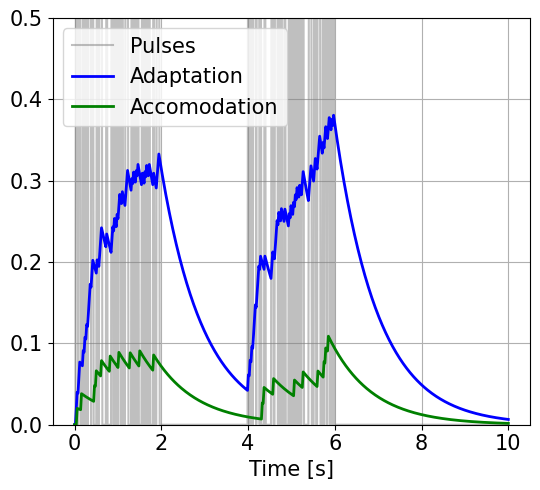

In [11]:
t = np.linspace(0, 10, 500)
dt = t[1] - t[0]

input_signal = np.zeros_like(t)
input_times = sorted(np.random.uniform(0, 2, size=50))

for pulse_time in input_times:
    input_signal[np.abs(t - pulse_time).argmin()] = 1

input_times = sorted(np.random.uniform(4, 6, size=50))
for pulse_time in input_times:
    input_signal[np.abs(t - pulse_time).argmin()] = 1

spikes = np.zeros_like(t)
input_times = sorted(np.random.uniform(0, 2, size=10))

for pulse_time in input_times:
    spikes[np.abs(t - pulse_time).argmin()] = 1

input_times = sorted(np.random.uniform(4, 6, size=10))
for pulse_time in input_times:
    spikes[np.abs(t - pulse_time).argmin()] = 1

# Parameters for the leaky integrator
tau = 1.0  # time constant
leak = 1 / tau

# Output signal: leaky integration of the input
output = np.zeros_like(t)
output2 = np.zeros_like(t)
for i in range(1, len(t)):
    output[i] = output[i-1] + dt * (-leak * output[i-1] + input_signal[i])
    output2[i] = output2[i-1] + dt * (-leak * output2[i-1] + spikes[i])

# Plotting
plt.figure(figsize=(5.5, 5))
plt.plot(t, input_signal, label='Pulses', color='gray', alpha=.5)
plt.plot(t, output, label='Adaptation', color='blue', linewidth=2.0)
plt.plot(t, output2, label='Accomodation', color='green', linewidth=2.0)

plt.xlabel('Time [s]', fontsize=15)
plt.ylim(0, .5)
plt.grid()
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig("leaky.png", dpi=100)

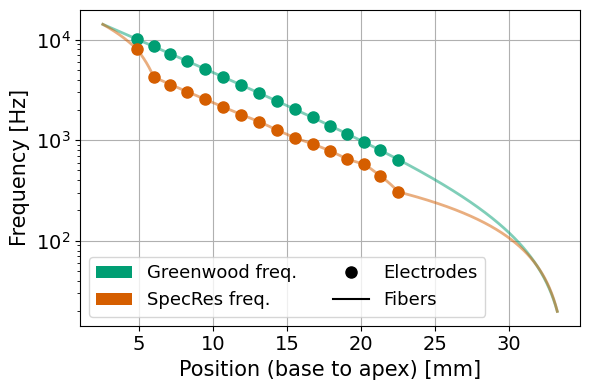

In [12]:
# fiber_freq = get_fiber_freq_position(tp, 150, 10_500)
# electrode_freq = phast.scs.ab.defaults.virtual_channel_frequencies(tp.electrode.position.size, False)

from phast.scs.ab.defaults import ELECTRODE_FREQ_LOWER, ELECTRODE_FREQ_UPPER
electrode_freq = np.r_[ELECTRODE_FREQ_LOWER, ELECTRODE_FREQ_UPPER[-1]]
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fiber_freq = np.interp(
    tp.position[::-1], 
    np.r_[tp.position[-1], tp.electrode.position[::-1], tp.position[0]], 
    np.r_[tp.greenwood_f.max(), electrode_freq[::-1], tp.greenwood_f.min()], 
)[::-1]


f, (ax1) = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)
line1 = '#009E73'  # Slate Blue
line2 = '#D55E00'  # Aqua Mint

ax1.plot(tp.electrode.position, tp.electrode.greenwood_f, marker='o', label="Greenwood Freq.", color=line1, linestyle='none', markersize=8)
ax1.plot(tp.electrode.position, electrode_freq, marker='o', label="Specres Freq.", color=line2, markersize=8, linestyle='none',)

ax1.plot(tp.position, tp.greenwood_f, label="Greenwood (Fiber)",  color=line1, alpha=.5, lw=2,)
ax1.plot(tp.position, fiber_freq, label="Specres 120 (Fiber)",  color=line2, alpha=.5, lw=2,)


ax1.set_yscale("log")
ax1.grid()

ax1.set_xlabel("Position (base to apex) [mm]", fontsize=15)
ax1.set_ylabel("Frequency [Hz]", fontsize=15)

custom_lines = [
    Patch(facecolor=line1, label='Greenwood freq.'),
    Patch(facecolor=line2, label='SpecRes freq.'),
    Line2D([0], [0], color='black', lw=2, label='Electrodes', marker='o', linestyle='none', markersize=8),
    Line2D([0], [0], color='black', label='Fibers'),
]

ax1.legend(handles=custom_lines, ncol=2, fontsize=13)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
# plt.savefig("fiber_freq.png", dpi=400)


In [13]:
neurogram_specres = specres(robin_sound)

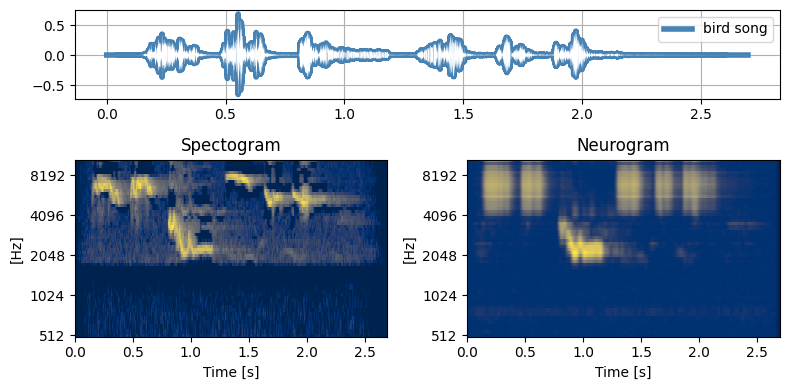

In [14]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 2,  height_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(np.arange(len(y)) * (1/sr), y, label='bird song', color='#4682B4', linewidth=4)
ax1.plot(np.arange(len(y)) * (1/sr), y, color='white', linewidth=.05)
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
t = np.arange(S_db.shape[1]) * hops * (1 / sr)
cmap = 'cividis'

ax2.pcolormesh(
    t, neurogram_specres.frequencies, S_db, cmap=cmap
)

ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)
# t = np.arange(bg.data.shape[1]) * bg.ng.bin_width,

sp_data_phast = np.vstack(
    [
        scipy.signal.resample(neurogram_specres.data[i], S_db.shape[1])
        for i in range(neurogram_specres.data.shape[0])
    ]
)

img = ax3.pcolormesh(
    t, neurogram_specres.frequencies, sp_data_phast, cmap=cmap
)


# img = ax3.pcolormesh(
#     np.arange(bg.data.shape[1]) * bg.ng.bin_width, bg.mel_scale, bg.data, cmap=cmap
# )
ax2.set_title("Spectogram")
ax3.set_title("Neurogram")

ax2.set_ylabel("[Hz]")
ax2.set_yscale("log", base=2)
ax2.set_yticks([pow(2, i) for i in range(9, 14)], [pow(2, i) for i in range(9, 14)])
ax2.set_ylim(500, None)
ax2.set_xlim(0, np.max(t))

# ax1.set_ylabel("amplitude")
ax3.set_ylabel("[Hz]")

for ax in ax2, ax3:
    ax.set_xlabel("Time [s]")
plt.tight_layout()


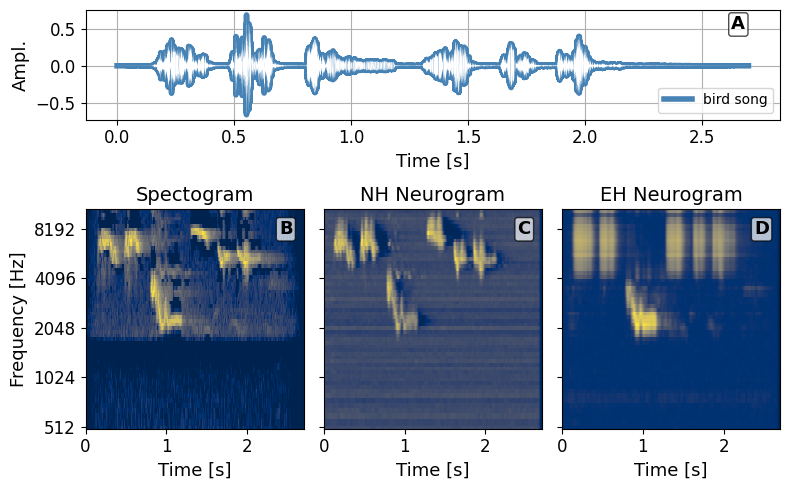

In [15]:
fig = plt.figure(figsize=(8, 5))
gs = fig.add_gridspec(2, 3,  height_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(np.arange(len(y)) * (1/sr), y, label='bird song', color='#4682B4', linewidth=4)
ax1.plot(np.arange(len(y)) * (1/sr), y, color='white', linewidth=.05)
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
t = np.arange(S_db.shape[1]) * hops * (1 / sr)
cmap = 'cividis'

img2 = ax2.pcolormesh(
    t, neurogram_specres.frequencies, S_db, cmap=cmap
)
# fig.colorbar(img2, ax=ax2, orientation="horizontal", location='top')

ax2.set_ylabel("Frequency [Hz]", fontsize=13)
ax2.set_ylim(500, None)
ax2.set_yscale("log", base=2)
ax2.set_yticks([pow(2, i) for i in range(9, 14)], [pow(2, i) for i in range(9, 14)], fontsize=12)
ax2.set_xlim(0, np.max(t))

ax3 = fig.add_subplot(gs[1, 1], sharex=ax2, sharey=ax2)
img3 = ax3.pcolormesh(
    t, neurogram_specres.frequencies, sp_data, cmap=cmap, vmax=1
)

# fig.colorbar(img3, ax=ax3,  orientation="horizontal", location='top')

ax4 = fig.add_subplot(gs[1, 2], sharex=ax2, sharey=ax2)

img4 = ax4.pcolormesh(
    t, neurogram_specres.frequencies, sp_data_phast, cmap=cmap, vmax=1
)
# fig.colorbar(img4, ax=ax4, orientation="horizontal", location='top')
ax2.set_title("Spectogram", fontsize=14)
ax3.set_title("NH Neurogram", fontsize=14)
ax4.set_title("EH Neurogram", fontsize=14)

for ax in ax3, ax4:
    ax.tick_params(labelleft=False)
    


ax1.set_ylabel("Ampl.", fontsize=13)
# ax4.set_ylabel("[Hz]")

for ax, label in zip((ax1, ax2, ax3, ax4), "ABCD"):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel("Time [s]", fontsize=13)
    ax.text(0.95, 0.95, label,
        transform=ax.transAxes,
        fontsize=13, fontweight='bold',
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.15'))
plt.tight_layout()

# fig.savefig("robin_neurogram_combined.png", dpi=600)

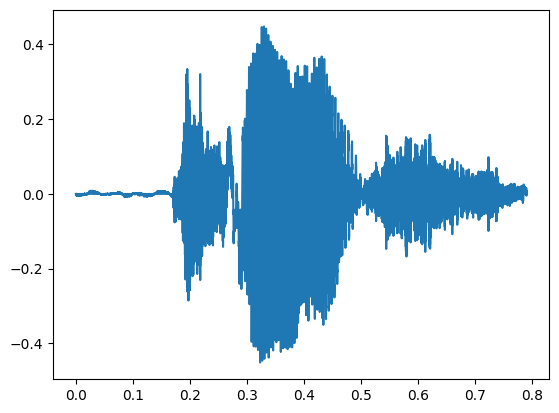

In [16]:
choice = os.path.join(data_path, "Choice.wav")
y, sr = librosa.load(choice, sr=44100)
plt.plot(np.arange(len(y)) / sr, y)

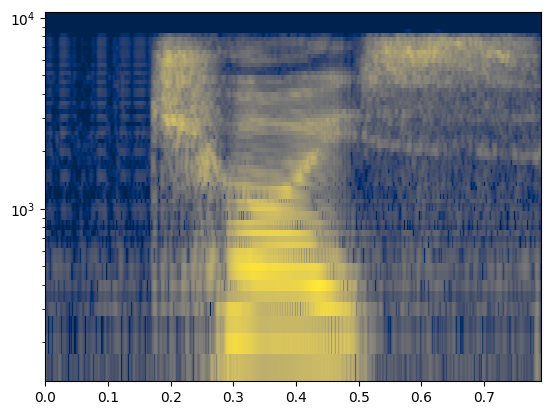

In [17]:
S_db = get_spectrogram(y, sr, 512, 32)

t = np.arange(S_db.shape[1]) * 32 * (1 / sr)
cmap = 'cividis'

plt.pcolormesh(
    t, mel_scale, S_db, cmap=cmap
)
plt.yscale("log")

In [18]:
specres_choice_ng = specres(choice)
reconstructed_specres = reconstruct(specres_choice_ng)

bruce_choice_ng = bruce(choice)
reconstructed_bruce = reconstruct(bruce_choice_ng)

original, fs = librosa.load(choice, sr=44100)
reconstructed_bruce = scipy.signal.resample(reconstructed_bruce, original.size)
reconstructed_specres = scipy.signal.resample(reconstructed_specres, original.size)


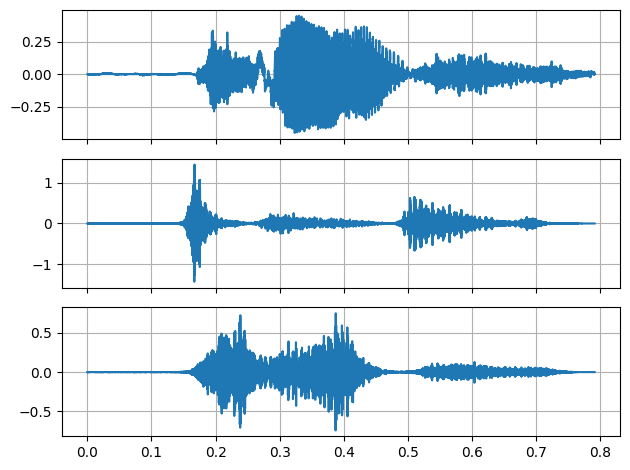

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
t = np.arange(len(original)) / fs
ax1.plot(t, original)
ax2.plot(t, reconstructed_bruce)
ax3.plot(t, reconstructed_specres)

for a in ax1, ax2, ax3:
    a.grid()
plt.tight_layout()

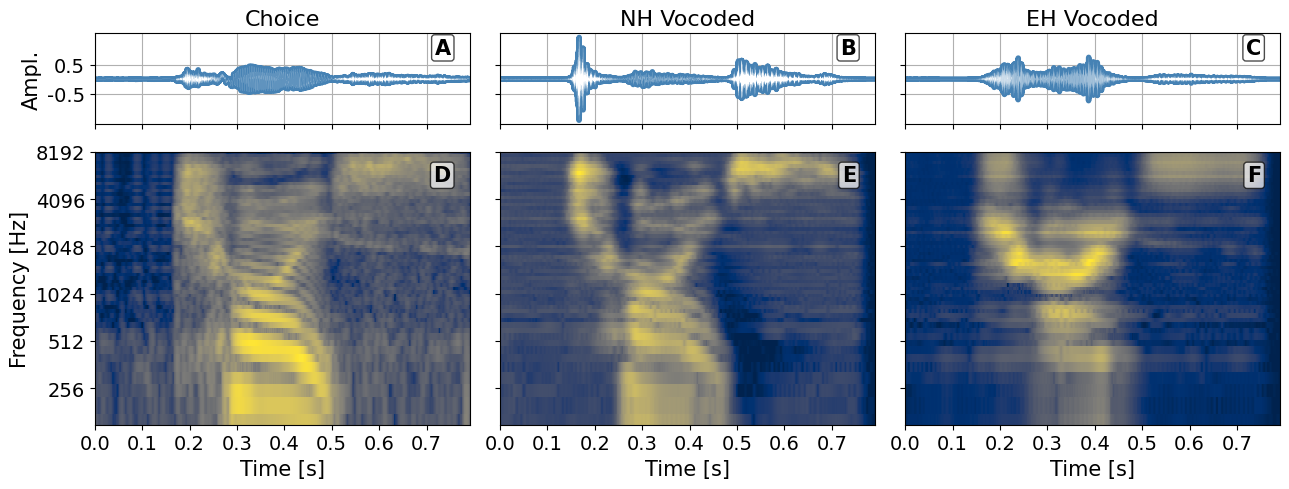

In [20]:
f, axes = plt.subplots(2, 3, sharey="row", sharex=True, figsize=(13, 5), height_ratios=[1, 3])

m = 2
# fs = 16000  * m
N_FFT = 512 
N_HOP = 32

for ((ax1, ax2), y, title) in zip(axes.T, (original, reconstructed_bruce, reconstructed_specres), ("Choice", "NH Vocoded", "EH Vocoded")):
    # y = librosa.resample(y.copy(), orig_sr=16000, target_sr=fs)
    t_sound = np.arange(len(y)) / fs   
    ax1.plot(t_sound, y, color='#4682B4', linewidth=4)
    ax1.plot(t_sound, y, color='white', linewidth=.05)
    spectrogram = get_spectrogram(y, fs, N_FFT * m, N_HOP * m)
    t_spec = np.arange(spectrogram.shape[1]) * N_HOP*m * (1 / fs)
    ax2.pcolormesh(t_spec, mel_scale, spectrogram, vmin=-80, vmax=0, cmap=cmap)
    ax1.set_title(title, fontsize=16)
    ax1.set_yticks([-.5, .5], [-.5, .5], fontsize=14)
    ax2.set_xlabel("Time [s]", fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax1.grid()
    display(Audio(data=y, rate=fs, element_id=title))


axes[0][0].set_ylabel("Ampl.", fontsize=15)
ax2 = axes[1][0]
ax2.set_ylabel("Frequency [Hz]",  fontsize=15)
ax2.set_yscale("log", base=2)
ax2.set_yticks([pow(2, i) for i in range(8, 14)], [pow(2, i) for i in range(8, 14)], fontsize=14)
ax2.set_ylim(min_freq, 8200)
ax2.set_xlim(0, np.max(t))

for ax, label in zip(axes.ravel(), "ABCDEF"):
    ax.text(0.95, 0.95, label,
        transform=ax.transAxes,
        fontsize=15, fontweight='bold',
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.15'))
    
plt.tight_layout()
# plt.savefig("choice_no_noise.png", dpi=600)

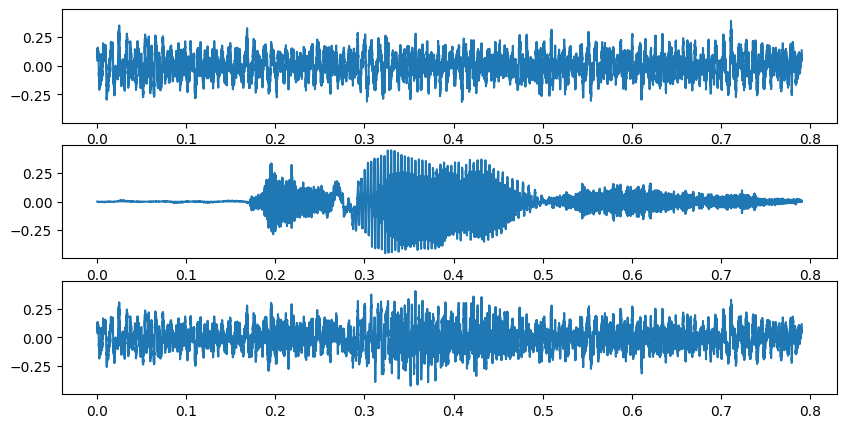

In [21]:
def rms_db(y):
    rms = np.sqrt(np.mean(y**2))
    return 20 * np.log10(rms)

def mix_v2(stim, noise, snr):
    mask = np.nonzero(stim)
    db_stim = rms_db(stim[mask])
    db_noise = rms_db(noise)
    db_tgt = db_noise + snr
    gain = 10 ** ((db_tgt - db_stim) / 20)
    stim_scaled = stim * gain
    mixed = noise + stim_scaled
    return mixed   

def scale_to_target_dbfs(y, target_dbfs):
    current_dbfs = rms_db(y)
    diff = target_dbfs - current_dbfs
    gain = 10 ** (diff / 20)
    return y * gain

# choice
snr = -4
noise = os.path.join(data_path, "din/tripletnoise.wav")
noise_y, sr = librosa.load(noise, sr=None)
choice_y, sr = librosa.load(choice, sr=sr)
noise_seg = noise_y[100:100+ len(choice_y)]
mixed = scale_to_target_dbfs(mix_v2(choice_y, noise_seg, snr), rms_db(choice_y))
t = np.arange(len(choice_y)) / sr

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharey=True)
ax1.plot(t, noise_seg)
ax2.plot(t, choice_y)
ax3.plot(t, mixed)

display(Audio(data=mixed, rate=sr))
filename = f"choice_triplet{snr}db_snr.wav"
sf.write(filename, mixed, sr)

In [22]:
specres_choice_ng = specres(filename)
reconstructed_specres = reconstruct(specres_choice_ng)

bruce_choice_ng = bruce(filename)
reconstructed_bruce = reconstruct(bruce_choice_ng)

original, fs = librosa.load(filename, sr=44100)
reconstructed_bruce = scipy.signal.resample(reconstructed_bruce, original.size)
reconstructed_specres = scipy.signal.resample(reconstructed_specres, original.size)

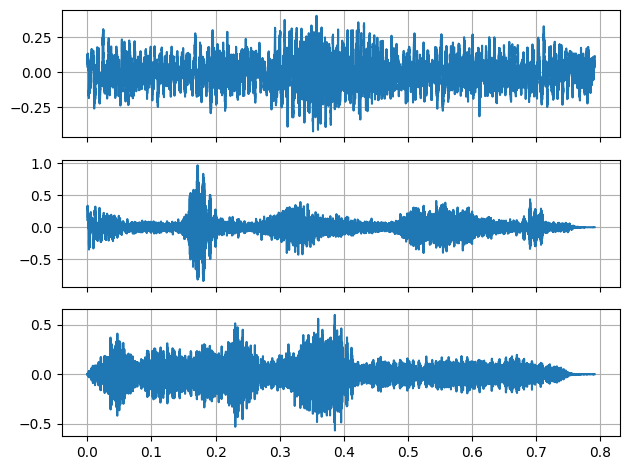

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
t = np.arange(len(original)) / fs
ax1.plot(t, original)
ax2.plot(t, reconstructed_bruce)
ax3.plot(t, reconstructed_specres)

for a in ax1, ax2, ax3:
    a.grid()
plt.tight_layout()

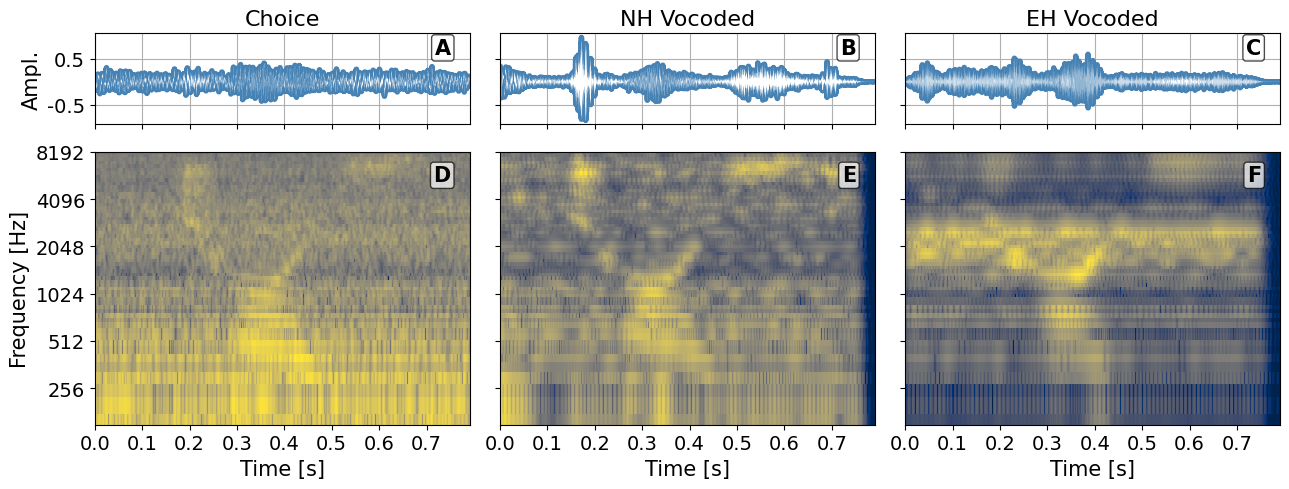

In [24]:
f, axes = plt.subplots(2, 3, sharey="row", sharex=True, figsize=(13, 5), height_ratios=[1, 3])

N_FFT = int(512)
N_HOP = int(32)

for ((ax1, ax2), y, title) in zip(axes.T, (original, reconstructed_bruce, reconstructed_specres), ("Choice", "NH Vocoded", "EH Vocoded")):
    t_sound = np.arange(len(y)) / fs   
    ax1.plot(t_sound, y, color='#4682B4', linewidth=4)
    ax1.plot(t_sound, y, color='white', linewidth=.05)
    spectrogram = get_spectrogram(y, fs, N_FFT, N_HOP)
    t_spec = np.arange(spectrogram.shape[1]) * N_HOP * (1 / fs)
    ax2.pcolormesh(t_spec, mel_scale, spectrogram, vmin=-80, vmax=0, cmap=cmap)
    ax1.set_title(title, fontsize=16)
    ax1.set_yticks([-.5, .5], [-.5, .5], fontsize=14)
    ax2.set_xlabel("Time [s]", fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax1.grid()
    display(Audio(data=y, rate=fs, element_id=title))


axes[0][0].set_ylabel("Ampl.", fontsize=15)
ax2 = axes[1][0]
ax2.set_ylabel("Frequency [Hz]",  fontsize=15)
ax2.set_yscale("log", base=2)
ax2.set_yticks([pow(2, i) for i in range(8, 14)], [pow(2, i) for i in range(8, 14)], fontsize=14)
ax2.set_ylim(min_freq, 8200)
ax2.set_xlim(0, np.max(t))

for ax, label in zip(axes.ravel(), "ABCDEF"):
    ax.text(0.95, 0.95, label,
        transform=ax.transAxes,
        fontsize=15, fontweight='bold',
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.15'))
    
plt.tight_layout()
# plt.savefig(f"choice_noise_{snr}db.png", dpi=600)

In [25]:
neurogram_bruce_spikes = bruce(filename, window_size=None, normalize=True)

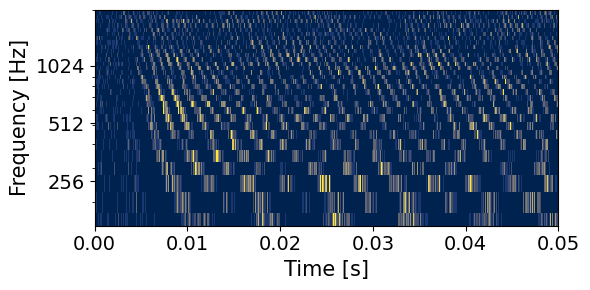

In [ ]:
f, ax = plt.subplots(figsize=(6, 3))

ax.pcolormesh(np.arange(neurogram_bruce_spikes.data.shape[1]) * neurogram_bruce_spikes.dt, 
              neurogram_bruce_spikes.frequencies, neurogram_bruce_spikes.data, 
              cmap=cmap, vmin=0., vmax=0.5)
ax.set_xlim(0, 0.05)
ax.set_yscale("log")
ax.set_ylabel("Frequency [Hz]",  fontsize=15)
ax.set_yticks([pow(2, i) for i in range(8, 14)], [pow(2, i) for i in range(8, 14)], fontsize=14)
ax.set_ylim(min_freq, 2000)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Time [s]", fontsize=15);
plt.tight_layout()
# plt.savefig("choice_bruce_ng_zoomed.png", dpi=600)